In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
YEARS_HISTORY = [i for i in range(1990, 2018, 1)]
YEARS_FORECAST = [i for i in range(2018, 2041, 1)]
YEARS_ALL = YEARS_HISTORY + YEARS_FORECAST

In [3]:
df_pop = pd.read_csv('population_estimates.csv')
df_gdp = pd.read_csv('gdp.csv')
df_pop.columns = [int(i) if i.isdigit() else i for i in df_pop.columns]
df_gdp.columns = [int(i) if i.isdigit() else i for i in df_gdp.columns]
COUNTRIES = ['European Union', 'China', 'United States', 'India', 'Latin America & Caribbean', 'Sub-Saharan Africa', 'Japan',
             'Middle East & North Africa', 'Russian Federation', 'Canada', 'Australia', 'World']
# CODES OF AGE GROUPS (25-69 yo). OTHER AGES DON'T PRODUCE VALUE ADDED IN GENERAL
CODES = ['SP.POP.2529.', 'SP.POP.3034.', 'SP.POP.3539.', 'SP.POP.4044.', 'SP.POP.4549.', 'SP.POP.5054.', 'SP.POP.5559.', 'SP.POP.6064.', 'SP.POP.6469.']
CODES = [i + 'MA' for i in CODES] + [i + 'FE' for i in CODES]  # male + female

In [4]:
# FORM POPULATION (25-69) DICTIONARY FROM RAW-DATAFRAME
population = {country: {year: 0 for year in YEARS_ALL} for country in COUNTRIES}
for index, row in df_pop.iterrows():
    country = row['Country Name']
    code = row['Indicator Code']
    if country in COUNTRIES and code in CODES:
        for year in YEARS_ALL:
            population[country][year] += float(row[year])

In [5]:
# FORM GDP DICTIONARY FROM RAW-DATAFRAME
gdp = {row['Country Name']: {year: row[year] for year in YEARS_HISTORY} for index, row in df_gdp.iterrows() if row['Country Name'] in COUNTRIES}

# CALC GDP PER CAPITA (25-69 only)
gdp_per_cap = {country: {year: (gdp[country][year] / population[country][year]) for year in YEARS_HISTORY} for country in COUNTRIES}

# CALC PER CAPITA YEARLY GROWTH
gdp_per_cap_growth = {country: {year: gdp_per_cap[country][year] / gdp_per_cap[country][year - 1] for year in YEARS_HISTORY if year != 1990} for country in COUNTRIES}

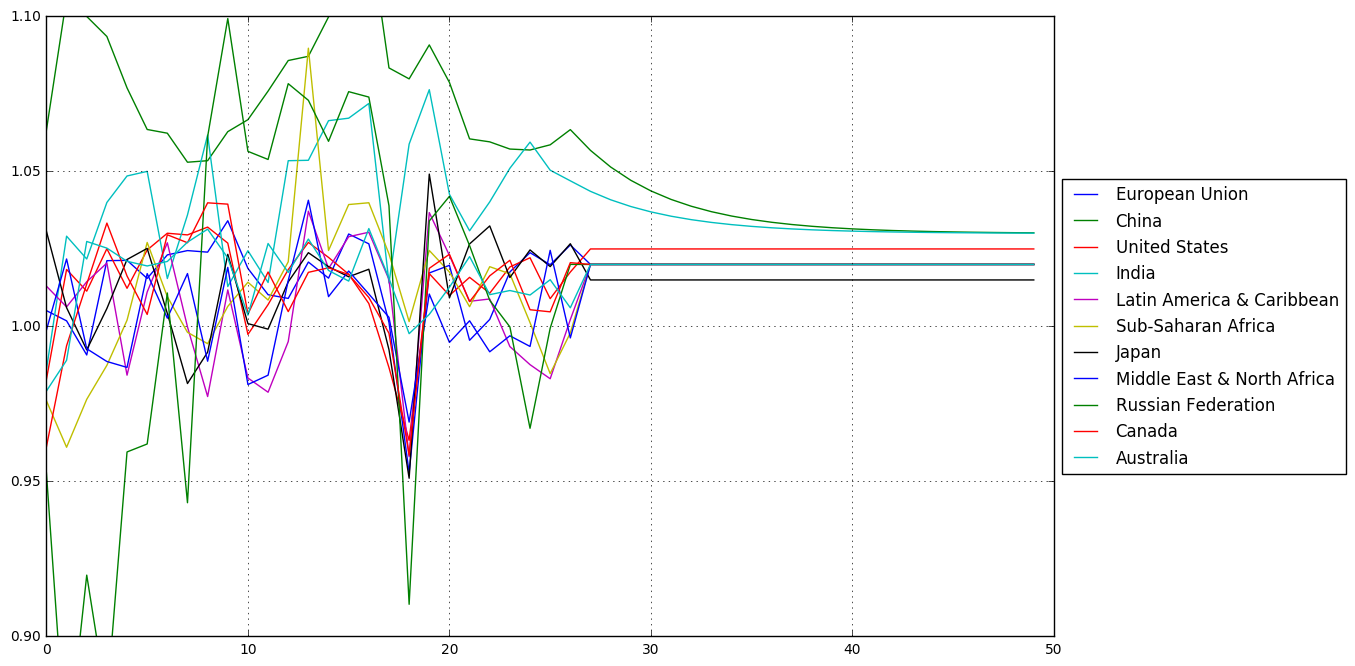

In [14]:
# PLOT GDP PER CAPITA GROWTH
plt.figure(figsize=[13, 8])
[plt.plot(gdp_per_cap_growth[country].values(), label=country) for country in COUNTRIES[:-1]]
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(top=1.1, bottom=0.9)
plt.grid()

In [15]:
# FORECAST GROWTH FOR 2018 - 2040
for country in COUNTRIES:
    for year in YEARS_FORECAST:
        if country in ['European Union', 'Australia', 'Canada']:
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'United States':
            gdp_per_cap_growth[country][year] = 1.025
        if country in ['China', 'India']:
            gdp_per_cap_growth[country][year] = (gdp_per_cap_growth[country][year - 1] - 1) * 0.8 + 1.006
        if country == 'Japan':
            gdp_per_cap_growth[country][year] = 1.015
        if country == 'Latin America & Caribbean':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'Middle East & North Africa':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'Russian Federation':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'World':
            gdp_per_cap_growth[country][year] = 1.02
        if country == 'Sub-Saharan Africa':
            gdp_per_cap_growth[country][year] = 1.02

In [16]:
# CALC GDP PER CAPITA FOR 2018 - 2040 WITH FORECASTED DATA
for country in COUNTRIES:
    for year in YEARS_FORECAST:
        gdp_per_cap[country][year] = gdp_per_cap[country][year - 1] * gdp_per_cap_growth[country][year]

# CALC GDP FOR 2018 - 2040 WITH FORECASTED DATA
gdp = {country: {year: gdp_per_cap[country][year] * population[country][year] for year in YEARS_ALL} for country in COUNTRIES}

In [9]:
gdp['Other'] = dict()
gdp['Other Western'] = dict()

for year in YEARS_ALL:
    # CALC GDP FOR ALL OTHER COUNTRIES
    gdp['Other'][year] = gdp['World'][year] - sum([gdp[country][year] for country in COUNTRIES[:-1]])
    # SUM GDP FOR AUSTRALIA AND CANADA TO NEW CATEGORY
    gdp['Other Western'][year] = gdp['Australia'][year] + gdp['Canada'][year]

del gdp['Australia']
del gdp['Canada']

In [10]:
# NORMALIZE DATA FOR CHART WITH Y=[0;1]
for year in YEARS_ALL:
    for country in COUNTRIES[:-3] + ['Other'] + ['Other Western']:
        gdp[country][year] = gdp[country][year] / gdp['World'][year]

(0.0, 1)

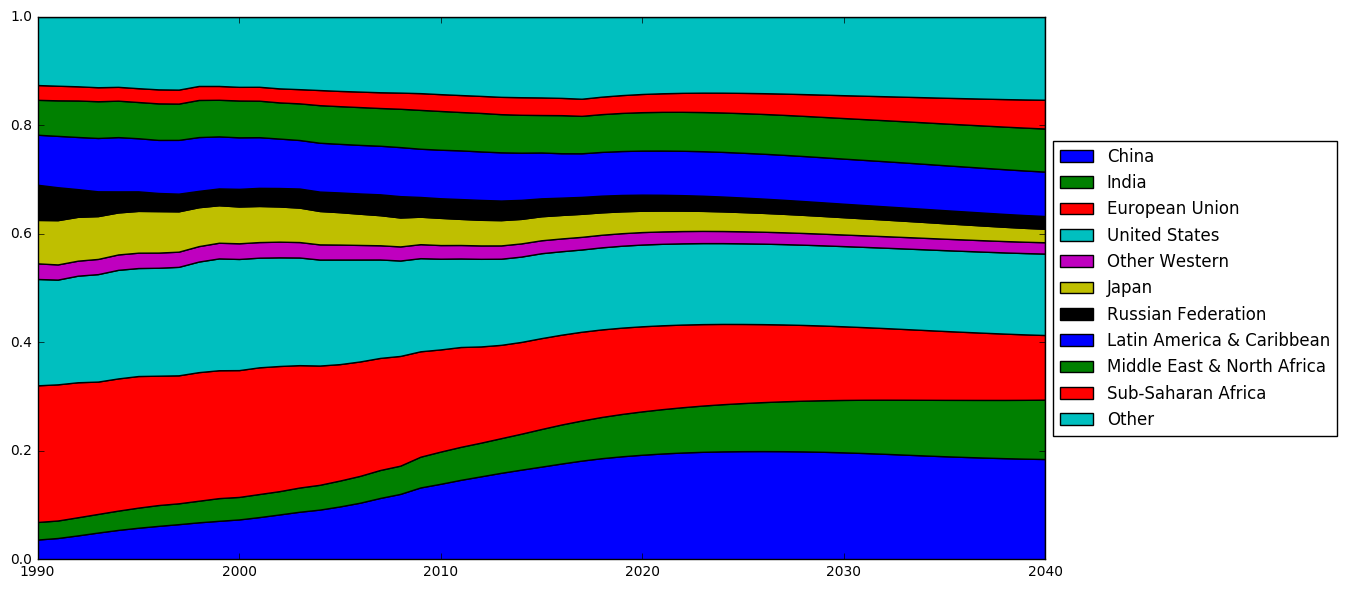

In [11]:
plt.figure(figsize=[13, 7])
plt.stackplot(YEARS_ALL,
              gdp['China'].values(),
              gdp['India'].values(),
              gdp['European Union'].values(),
              gdp['United States'].values(),
              gdp['Other Western'].values(),
              gdp['Japan'].values(),
              gdp['Russian Federation'].values(),
              gdp['Latin America & Caribbean'].values(),
              gdp['Middle East & North Africa'].values(),
              gdp['Sub-Saharan Africa'].values(),
              gdp['Other'].values(),
              labels=['China', 'India', 'European Union', 'United States', 'Other Western', 'Japan', 'Russian Federation', 'Latin America & Caribbean', 'Middle East & North Africa', 'Sub-Saharan Africa', 'Other'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(top=1)